In [1]:
# !pip install datasets transformers seqeval nlpaug matplotlib 
!pip install torch datasets transformers nlpaug seqeval




[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import random
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
from seqeval.metrics import precision_score, recall_score, f1_score
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import torch

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)


/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load CoNLL-2003 English dataset
conll = load_dataset("conll2003",trust_remote_code=True)



## 2. Exploratory Data Analysis (EDA) of CoNLL-2003

Before evaluating the models under noisy conditions, let's perform some basic exploratory data analysis on the original CoNLL-2003 dataset. This helps understand the dataset's characteristics, such as the distribution of sentence lengths and Named Entity Recognition (NER) tags. As noted in the accompanying report, this step was initially bypassed in favour of direct experimentation, but understanding these distributions provides valuable context.

We will look at:
- Dataset size (number of sentences per split).
- Distribution of sentence lengths (min, max, mean, median, std dev).
- Distribution of NER tags (counts and percentages per split).

--- CoNLL-2003 Dataset Analysis ---

--- TRAIN SPLIT ---
Number of sentences: 14041
Sentence length statistics:
  Min: 1
  Max: 113
  Mean: 14.50
  Median: 10.0
  Std Dev: 11.60

NER Tag distribution (Total Tags: 203621):
  O: 169578 (83.28%)
  B-LOC: 7140 (3.51%)
  B-MISC: 3438 (1.69%)
  B-ORG: 6321 (3.10%)
  B-PER: 6600 (3.24%)
  I-LOC: 1157 (0.57%)
  I-MISC: 1155 (0.57%)
  I-ORG: 3704 (1.82%)
  I-PER: 4528 (2.22%)

--- VALIDATION SPLIT ---
Number of sentences: 3250
Sentence length statistics:
  Min: 1
  Max: 109
  Mean: 15.80
  Median: 11.0
  Std Dev: 12.60

NER Tag distribution (Total Tags: 51362):
  O: 42759 (83.25%)
  B-LOC: 1837 (3.58%)
  B-MISC: 922 (1.80%)
  B-ORG: 1341 (2.61%)
  B-PER: 1842 (3.59%)
  I-LOC: 257 (0.50%)
  I-MISC: 346 (0.67%)
  I-ORG: 751 (1.46%)
  I-PER: 1307 (2.54%)

--- TEST SPLIT ---
Number of sentences: 3453
Sentence length statistics:
  Min: 1
  Max: 124
  Mean: 13.45
  Median: 9.0
  Std Dev: 11.55

NER Tag distribution (Total Tags: 46435):
  O: 38323 (82

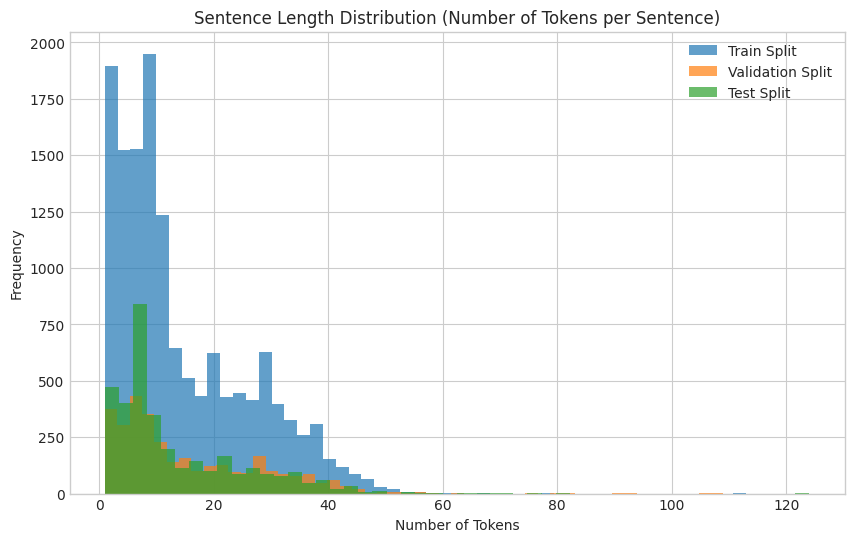

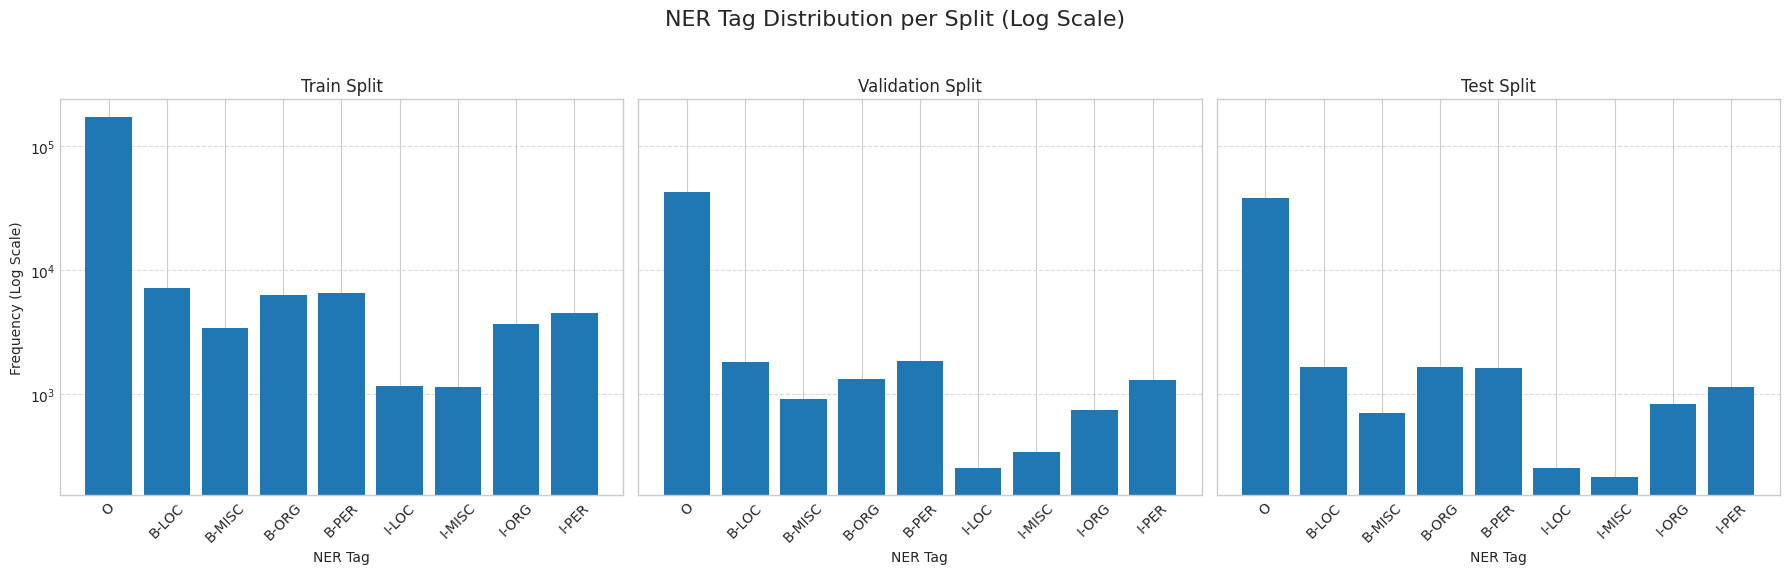

In [5]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt # Make sure matplotlib is installed and imported

# Get NER tag names (ensure this runs after dataset loading)
ner_tag_names = conll['train'].features['ner_tags'].feature.names

print("--- CoNLL-2003 Dataset Analysis ---")

stats = {} # To store stats for plotting later

for split_name in ['train', 'validation', 'test']:
    print(f"\n--- {split_name.upper()} SPLIT ---")
    split_data = conll[split_name]
    num_sentences = len(split_data)
    print(f"Number of sentences: {num_sentences}")

    # Calculate sentence lengths
    sentence_lengths = [len(example['tokens']) for example in split_data]
    stats[split_name] = {'lengths': sentence_lengths}
    print(f"Sentence length statistics:")
    print(f"  Min: {np.min(sentence_lengths)}")
    print(f"  Max: {np.max(sentence_lengths)}")
    print(f"  Mean: {np.mean(sentence_lengths):.2f}")
    print(f"  Median: {np.median(sentence_lengths)}")
    print(f"  Std Dev: {np.std(sentence_lengths):.2f}")

    # Calculate NER tag distribution
    all_tags_ids = [tag_id for example in split_data for tag_id in example['ner_tags']]
    tag_counts = Counter(all_tags_ids)
    stats[split_name]['tag_counts'] = tag_counts
    total_tags = sum(tag_counts.values())

    print(f"\nNER Tag distribution (Total Tags: {total_tags}):")
    # Sort tags for consistent order, putting 'O' first if present
    sorted_tags_ids = sorted(tag_counts.keys(), key=lambda x: (ner_tag_names[x] != 'O', ner_tag_names[x]))
    for tag_id in sorted_tags_ids:
        tag_name = ner_tag_names[tag_id]
        count = tag_counts[tag_id]
        percentage = (count / total_tags) * 100
        print(f"  {tag_name}: {count} ({percentage:.2f}%)")

# --- Plotting ---
print("\n--- Generating Plots ---")
plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style

# Plot Sentence Length Distributions
plt.figure(figsize=(10, 6))
for split_name in ['train', 'validation', 'test']:
    plt.hist(stats[split_name]['lengths'], bins=50, alpha=0.7, label=f'{split_name.capitalize()} Split')
plt.title('Sentence Length Distribution (Number of Tokens per Sentence)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


# Plot NER Tag Distributions (Log Scale)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('NER Tag Distribution per Split (Log Scale)', fontsize=16)

for i, split_name in enumerate(['train', 'validation', 'test']):
    tag_counts = stats[split_name]['tag_counts']
    sorted_tags_ids = sorted(tag_counts.keys(), key=lambda x: (ner_tag_names[x] != 'O', ner_tag_names[x]))
    tag_names_sorted = [ner_tag_names[tag_id] for tag_id in sorted_tags_ids]
    tag_values_sorted = [tag_counts[tag_id] for tag_id in sorted_tags_ids]

    ax = axes[i]
    bars = ax.bar(tag_names_sorted, tag_values_sorted)
    ax.set_title(f'{split_name.capitalize()} Split')
    ax.set_xlabel('NER Tag')
    if i == 0:
        ax.set_ylabel('Frequency (Log Scale)')
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.set_yscale('log') # Use log scale due to high frequency of 'O' tag
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

## Analysis of CoNLL-2003 EDA Results

The exploratory data analysis provides valuable insights into the structure and composition of the CoNLL-2003 dataset, addressing the need for foundational data scrutiny highlighted in the project report.

**Key Findings:**

1.  **Dataset Size:** The dataset is split into training (14,041 sentences), validation (3,250 sentences), and test (3,453 sentences) sets, following standard conventions.

2.  **Sentence Length:**
    *   Sentence lengths vary significantly across all splits, ranging from single-token sentences up to over 100 tokens (Max train: 113, validation: 109, test: 124).
    *   The average sentence length is around 13-16 tokens (Train: 14.50, Valid: 15.80, Test: 13.45), with median lengths slightly lower (Train: 10, Valid: 11, Test: 9), indicating a skew towards shorter sentences.
    *   The standard deviations (around 11.5-12.6) confirm the wide spread in lengths.
    *   The generated histogram visually confirms this distribution, showing a high frequency of shorter sentences and a long tail of longer sentences.

3.  **NER Tag Distribution:**
    *   **Dominance of 'O' Tag:** The most striking observation is the overwhelming prevalence of the 'O' (Outside) tag, constituting approximately 82.5% - 83.3% of all tags across the three splits. This indicates a significant class imbalance, which is typical for NER tasks but crucial to acknowledge for model evaluation.
    *   **Entity Tag Frequencies:** Among the actual entity tags (B-*, I-*), Person (PER), Organization (ORG), and Location (LOC) tags are the most frequent 'B-' types, each representing around 3-3.6% of the total tags. Miscellaneous (MISC) tags are less common (1.5-1.8%). The 'I-' tags (continuation of entities) are generally less frequent than their corresponding 'B-' tags.
    *   **Consistency Across Splits:** The relative frequencies of different NER tags are remarkably consistent across the training, validation, and test sets. This suggests that the splits are well-balanced in terms of entity distribution, providing a reliable basis for training and evaluation.
    *   The generated bar plots (using a log scale) visually emphasize the dominance of the 'O' tag and allow comparison of the frequencies of the less common entity tags across splits.



In [6]:
print(conll["train"].features)
print(conll["train"][0])  # first training example of CoNLL




{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None), 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}
{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'cal

In [7]:
# Load tokenizers and models for each dataset
models = {}
tokenizers = {}

# CoNLL03 model (English)
model_conll_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizers["CoNLL03"] = AutoTokenizer.from_pretrained(model_conll_name)
models["CoNLL03"] = AutoModelForTokenClassification.from_pretrained(model_conll_name).to(device)



Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
label_maps = {
    ds: models[ds].config.id2label 
    for ds in ["CoNLL03"]
}
print(label_maps["CoNLL03"])  # e.g., {0: 'O', 1: 'B-PER', ...}


{0: 'O', 1: 'B-MISC', 2: 'I-MISC', 3: 'B-PER', 4: 'I-PER', 5: 'B-ORG', 6: 'I-ORG', 7: 'B-LOC', 8: 'I-LOC'}


In [9]:
# Augmenters for each noise type (using nlpaug)
spelling_aug = naw.SpellingAug()  # simulate spelling mistakes
typo_aug = nac.KeyboardAug(aug_char_min=1, aug_char_max=1, aug_char_p=1.0)  # keyboard typo (1 char)&#8203;:contentReference[oaicite:1]{index=1}
ocr_aug = nac.OcrAug()  # OCR character confusion&#8203;:contentReference[oaicite:2]{index=2}

def introduce_spelling_errors(tokens, error_rate):
    """Introduce spelling errors in a list of tokens with given fraction."""
    new_tokens = []
    for token in tokens:
        if token.strip() == "":  # skip empty
            new_tokens.append(token)
        elif random.random() < error_rate:
            # Replace token with a misspelled version (if augment returns list, take first)
            aug_token = spelling_aug.augment(token)
            if isinstance(aug_token, list):
                aug_token = aug_token[0]
            # Ensure no spaces (SpellingAug sometimes returns multiple words joined by space)
            aug_token = aug_token.replace(" ", "")
            new_tokens.append(aug_token)
        else:
            new_tokens.append(token)
    return new_tokens

def introduce_typo_errors(tokens, error_rate):
    """Introduce keyboard typo errors in tokens with given fraction."""
    new_tokens = []
    for token in tokens:
        if token.strip() == "":
            new_tokens.append(token)
        elif random.random() < error_rate:
            aug_token = typo_aug.augment(token)
            if isinstance(aug_token, list):
                aug_token = aug_token[0]
            new_tokens.append(aug_token)
        else:
            new_tokens.append(token)
    return new_tokens

def introduce_ocr_errors(tokens, error_rate):
    """Introduce OCR errors in tokens with given fraction."""
    new_tokens = []
    for token in tokens:
        if token.strip() == "":
            new_tokens.append(token)
        elif random.random() < error_rate:
            aug_token = ocr_aug.augment(token)
            if isinstance(aug_token, list):
                aug_token = aug_token[0]
            new_tokens.append(aug_token)
        else:
            new_tokens.append(token)
    return new_tokens

def introduce_sse(sentence_list, error_rate):
    """Introduce sentence shortening errors: truncate a fraction of sentences."""
    new_sentences = []
    for sent in sentence_list:
        if random.random() < error_rate:
            # drop 1 to 3 tokens from the end of the sentence (if length allows)
            drop_n = random.randint(1, min(3, len(sent)))
            new_sentences.append(sent[:-drop_n] if drop_n < len(sent) else sent)
        else:
            new_sentences.append(sent)
    return new_sentences


In [21]:
def evaluate_model(dataset, model, tokenizer, noise_type=None, error_rate=0.0, label_names=None):
    """Evaluate the model on the given dataset (list of sentences with tokens and tags).
       noise_type: one of {"spelling", "typo", "ocr", "sse", None}; error_rate: float.
       Returns precision, recall, f1."""
    true_tags_all = []
    pred_tags_all = []

    # Get label names - handle both dataset objects and list of dictionaries
    if label_names is None:
        if hasattr(dataset, 'features'):
            label_names = dataset.features["ner_tags"].feature.names
        else:
            # For list-based datasets, we need to get label names from the original dataset
            label_names = conll["train"].features["ner_tags"].feature.names

    # Decide which noise function to apply
    noise_func = None
    if noise_type == "spelling":
        noise_func = introduce_spelling_errors
    elif noise_type == "typo":
        noise_func = introduce_typo_errors
    elif noise_type == "ocr":
        noise_func = introduce_ocr_errors

    # If SSE, we'll apply after token-level noise (or on its own if no token noise)
    apply_sse = (noise_type == "sse")

    # Iterate over each sentence in dataset
    for example in dataset:
        tokens = example["tokens"]
        tags = example["ner_tags"]
        # Convert numeric tags to label strings using the pre-fetched label_names:
        label_list = [label_names[tag] for tag in tags]

        # Apply token-level noise if specified and not SSE
        corrupted_tokens = tokens
        if noise_func is not None:
            corrupted_tokens = noise_func(tokens, error_rate)

        # Apply sentence truncation noise if needed
        if apply_sse:
            # Here error_rate is fraction of sentences truncated.
            # We handle SSE outside this loop for consistency (see combination handling).
            pass  # (We will handle SSE separately below)

        # Use the tokenizer to prepare model inputs, align with tokens
        inputs = tokenizer(corrupted_tokens, is_split_into_words=True, return_tensors="pt").to(device)
        #inputs = {k: v.to(device) for k, v in inputs.items()}
        # Get model predictions
        outputs = model(**inputs)
        pred_ids = outputs.logits.argmax(dim=-1).squeeze().cpu().tolist()
        # Align predictions to original word indices
        word_ids = inputs.word_ids()  # map subword indices to original token indices
        pred_labels = []
        prev_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue  # skip special tokens
            if word_idx != prev_word_idx:  # new word
                # Handle cases where pred_ids might be an integer if only one token
                label_id = pred_ids[idx] if isinstance(pred_ids, list) else pred_ids
                pred_labels.append(model.config.id2label[label_id])
                prev_word_idx = word_idx
        # Now pred_labels should align with original tokens count
        # Pad predictions if shorter than true labels (due to truncation or model error)
        if len(pred_labels) < len(label_list):
             pred_labels += ['O'] * (len(label_list) - len(pred_labels))
        # Truncate predictions if longer than true labels (shouldn't happen often with word_ids)
        elif len(pred_labels) > len(label_list):
            pred_labels = pred_labels[:len(label_list)]

        true_tags_all.append(label_list)
        pred_tags_all.append(pred_labels)

    # Calculate metrics using seqeval
    precision = precision_score(true_tags_all, pred_tags_all)
    recall = recall_score(true_tags_all, pred_tags_all)
    f1 = f1_score(true_tags_all, pred_tags_all)
    return precision, recall, f1


In [22]:
# Define error rates as in paper
spell_typo_rates = [0.05, 0.10, 0.15, 0.20, 0.25]
ocr_rates = [0.05, 0.10, 0.15, 0.20, 0.25]
sse_rate = 0.20  # we'll truncate 20% of sentences
combo_scenarios = [
    {"name": "A", "spelling": 0.05, "typo": 0.05, "ocr": 0.05},
    {"name": "B", "spelling": 0.10, "typo": 0.10, "ocr": 0.10},
    {"name": "C", "spelling": 0.15, "typo": 0.15, "ocr": 0.15},
    {"name": "D", "spelling": 0.20, "typo": 0.20, "ocr": 0.20},
    {"name": "E", "spelling": 0.25, "typo": 0.25, "ocr": 0.25},
]


In [23]:

# Initialize results dictionary
results = {
    "CoNLL03": {"clean": None, "spelling": {}, "typo": {}, "ocr": {}, "sse": None, "combo": {}},
}


In [24]:

for ds, data in zip(["CoNLL03"], [conll]):
    test_data = data["test"]
    model = models[ds]
    tokenizer = tokenizers[ds]
    # Get label names once to pass to all evaluate_model calls
    label_names = test_data.features["ner_tags"].feature.names
    
    # Store original sentences once for use in all tests
    original_sentences = [ex["tokens"] for ex in test_data]
    
    # Step 1: Evaluate on clean test data
    try:
        prec, rec, f1 = evaluate_model(test_data, model, tokenizer, noise_type=None, error_rate=0.0, label_names=label_names)
        results[ds]["clean"] = (prec, rec, f1)
        print(f"\n{ds} (clean test): Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    except Exception as e:
        print(f"Error evaluating clean data: {e}")
    



CoNLL03 (clean test): Precision=0.9124, Recall=0.9237, F1=0.9180


In [25]:

for ds, data in zip(["CoNLL03"], [conll]):
    test_data = data["test"]
    model = models[ds]
    tokenizer = tokenizers[ds]
    # Get label names once to pass to all evaluate_model calls
    label_names = test_data.features["ner_tags"].feature.names
    
    # Store original sentences once for use in all tests
    original_sentences = [ex["tokens"] for ex in test_data]    
    # Step 2: Spelling noise in separate loop
    try:
        print(f"\n--- Evaluating Spelling Noise ---")
        for er in spell_typo_rates:
            p, r, f = evaluate_model(test_data, model, tokenizer, noise_type="spelling", error_rate=er, label_names=label_names)
            results[ds]["spelling"][er] = (p, r, f)
            print(f"{ds} Spelling {int(er*100)}%: F1={f:.3f}")
    except Exception as e:
        print(f"Error evaluating spelling noise: {e}")



--- Evaluating Spelling Noise ---
CoNLL03 Spelling 5%: F1=0.906
CoNLL03 Spelling 10%: F1=0.899
CoNLL03 Spelling 15%: F1=0.890
CoNLL03 Spelling 20%: F1=0.876
CoNLL03 Spelling 25%: F1=0.871


In [27]:

for ds, data in zip(["CoNLL03"], [conll]):
    test_data = data["test"]
    model = models[ds]
    tokenizer = tokenizers[ds]
    # Get label names once to pass to all evaluate_model calls
    label_names = test_data.features["ner_tags"].feature.names
    
    # Store original sentences once for use in all tests
    original_sentences = [ex["tokens"] for ex in test_data]    
    # Step 3: Typo noise in separate loop
    try:
        print(f"\n--- Evaluating Typo Noise ---")
        for er in spell_typo_rates:
            p, r, f = evaluate_model(test_data, model, tokenizer, noise_type="typo", error_rate=er, label_names=label_names)
            results[ds]["typo"][er] = (p, r, f)
            print(f"{ds} Typo {int(er*100)}%: F1={f:.3f}")
    except Exception as e:
        print(f"Error evaluating typo noise: {e}")



--- Evaluating Typo Noise ---
CoNLL03 Typo 5%: F1=0.901
CoNLL03 Typo 10%: F1=0.880
CoNLL03 Typo 15%: F1=0.860
CoNLL03 Typo 20%: F1=0.842
CoNLL03 Typo 25%: F1=0.819


In [28]:

for ds, data in zip(["CoNLL03"], [conll]):
    test_data = data["test"]
    model = models[ds]
    tokenizer = tokenizers[ds]
    # Get label names once to pass to all evaluate_model calls
    label_names = test_data.features["ner_tags"].feature.names
    
    # Store original sentences once for use in all tests
    original_sentences = [ex["tokens"] for ex in test_data]    
    # Step 4: OCR noise in separate loop
    try:
        print(f"\n--- Evaluating OCR Noise ---")
        for er in ocr_rates:
            p, r, f = evaluate_model(test_data, model, tokenizer, noise_type="ocr", error_rate=er, label_names=label_names)
            results[ds]["ocr"][er] = (p, r, f)
            print(f"{ds} OCR {int(er*100)}%: F1={f:.3f}")
    except Exception as e:
        print(f"Error evaluating OCR noise: {e}")



--- Evaluating OCR Noise ---
CoNLL03 OCR 5%: F1=0.898
CoNLL03 OCR 10%: F1=0.871
CoNLL03 OCR 15%: F1=0.847
CoNLL03 OCR 20%: F1=0.821
CoNLL03 OCR 25%: F1=0.810


In [29]:

for ds, data in zip(["CoNLL03"], [conll]):
    test_data = data["test"]
    model = models[ds]
    tokenizer = tokenizers[ds]
    # Get label names once to pass to all evaluate_model calls
    label_names = test_data.features["ner_tags"].feature.names
    
    # Store original sentences once for use in all tests
    original_sentences = [ex["tokens"] for ex in test_data]    
    # Step 5: SSE noise in separate loop
    try:
        print(f"\n--- Evaluating SSE Noise ---")
        # Create a truncated version of the entire test set for SSE
        truncated_sentences = introduce_sse(original_sentences, sse_rate)
        # Replace tokens in a copy of test_data with truncated tokens
        sse_test_data = []
        for ex, trunc_tokens in zip(test_data, truncated_sentences):
            trunc_len = len(trunc_tokens)
            orig_len = len(ex["tokens"])
            if trunc_len < orig_len:
                trunc_tags = ex["ner_tags"][:trunc_len]
            else:
                trunc_tags = ex["ner_tags"]
            sse_test_data.append({"tokens": trunc_tokens, "ner_tags": trunc_tags})
        
        p, r, f = evaluate_model(sse_test_data, model, tokenizer, noise_type=None, error_rate=0.0, label_names=label_names)
        results[ds]["sse"] = (p, r, f)
        print(f"{ds} SSE (truncate {int(sse_rate*100)}% sentences): F1={f:.3f}")
    except Exception as e:
        print(f"Error evaluating SSE noise: {e}")



--- Evaluating SSE Noise ---
CoNLL03 SSE (truncate 20% sentences): F1=0.915


In [30]:

for ds, data in zip(["CoNLL03"], [conll]):
    test_data = data["test"]
    model = models[ds]
    tokenizer = tokenizers[ds]
    # Get label names once to pass to all evaluate_model calls
    label_names = test_data.features["ner_tags"].feature.names
    
    # Store original sentences once for use in all tests
    original_sentences = [ex["tokens"] for ex in test_data]    
    # Step 6: Combined noise in separate loop
    try:
        print(f"\n--- Evaluating Combined Noise ---")
        for combo in combo_scenarios:
            print(f"Evaluating scenario {combo['name']}...")
            # Start with SSE applied:
            combo_sentences = introduce_sse(original_sentences, sse_rate)
            combo_data = []
            for ex, combo_tokens in zip(test_data, combo_sentences):
                combo_data.append({"tokens": combo_tokens, "ner_tags": ex["ner_tags"][:len(combo_tokens)]})
            
            # Apply spelling, typo, ocr sequentially on the truncated sentences
            combo_tokens_final = []
            for ex in combo_data:
                tokens = ex["tokens"]
                tokens = introduce_spelling_errors(tokens, combo["spelling"])
                tokens = introduce_typo_errors(tokens, combo["typo"])
                tokens = introduce_ocr_errors(tokens, combo["ocr"])
                combo_tokens_final.append(tokens)
            
            # Build final combo test set
            final_combo_data = []
            for ex, tokens in zip(combo_data, combo_tokens_final):
                final_combo_data.append({"tokens": tokens, "ner_tags": ex["ner_tags"][:len(tokens)]})
            
            p, r, f = evaluate_model(final_combo_data, model, tokenizer, noise_type=None, error_rate=0.0, label_names=label_names)
            results[ds]["combo"][combo["name"]] = (p, r, f)
            print(f"{ds} Combination {combo['name']}: F1={f:.3f}")
    except Exception as e:
        print(f"Error evaluating combined noise: {e}")



--- Evaluating Combined Noise ---
Evaluating scenario A...
CoNLL03 Combination A: F1=0.858
Evaluating scenario B...
CoNLL03 Combination B: F1=0.822
Evaluating scenario C...
CoNLL03 Combination C: F1=0.762
Evaluating scenario D...
CoNLL03 Combination D: F1=0.709
Evaluating scenario E...
CoNLL03 Combination E: F1=0.669


In [31]:

# Print grouped results summary
print("\n\n=== RESULTS SUMMARY ===")

for ds in results:
    print(f"\n{ds} Results:")
    
    # Print clean results
    if results[ds]["clean"]:
        prec, rec, f1 = results[ds]["clean"]
        print(f"  Clean: Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    
    # Print spelling results
    if results[ds]["spelling"]:
        print(f"  Spelling noise:")
        for er in sorted(results[ds]["spelling"].keys()):
            p, r, f = results[ds]["spelling"][er]
            print(f"    {int(er*100)}%: P={p:.4f}, R={r:.4f}, F1={f:.4f}")
    
    # Print typo results
    if results[ds]["typo"]:
        print(f"  Typo noise:")
        for er in sorted(results[ds]["typo"].keys()):
            p, r, f = results[ds]["typo"][er]
            print(f"    {int(er*100)}%: P={p:.4f}, R={r:.4f}, F1={f:.4f}")
    
    # Print OCR results
    if results[ds]["ocr"]:
        print(f"  OCR noise:")
        for er in sorted(results[ds]["ocr"].keys()):
            p, r, f = results[ds]["ocr"][er]
            print(f"    {int(er*100)}%: P={p:.4f}, R={r:.4f}, F1={f:.4f}")
    
    # Print SSE results
    if results[ds]["sse"]:
        p, r, f = results[ds]["sse"]
        print(f"  SSE noise (truncate {int(sse_rate*100)}% sentences): P={p:.4f}, R={r:.4f}, F1={f:.4f}")
    
    # Print combo results
    if results[ds]["combo"]:
        print(f"  Combined noise scenarios:")
        for combo_name in sorted(results[ds]["combo"].keys()):
            p, r, f = results[ds]["combo"][combo_name]
            print(f"    Scenario {combo_name}: P={p:.4f}, R={r:.4f}, F1={f:.4f}")



=== RESULTS SUMMARY ===

CoNLL03 Results:
  Clean: Precision=0.9124, Recall=0.9237, F1=0.9180
  Spelling noise:
    5%: P=0.8978, R=0.9150, F1=0.9063
    10%: P=0.8892, R=0.9093, F1=0.8992
    15%: P=0.8784, R=0.9014, F1=0.8897
    20%: P=0.8623, R=0.8902, F1=0.8760
    25%: P=0.8573, R=0.8851, F1=0.8710
  Typo noise:
    5%: P=0.8931, R=0.9093, F1=0.9011
    10%: P=0.8700, R=0.8895, F1=0.8796
    15%: P=0.8490, R=0.8718, F1=0.8602
    20%: P=0.8288, R=0.8555, F1=0.8420
    25%: P=0.8046, R=0.8341, F1=0.8191
  OCR noise:
    5%: P=0.8913, R=0.9046, F1=0.8979
    10%: P=0.8635, R=0.8778, F1=0.8706
    15%: P=0.8419, R=0.8515, F1=0.8467
    20%: P=0.8174, R=0.8256, F1=0.8215
    25%: P=0.8071, R=0.8121, F1=0.8096
  SSE noise (truncate 20% sentences): P=0.9095, R=0.9205, F1=0.9150
  Combined noise scenarios:
    Scenario A: P=0.8485, R=0.8682, F1=0.8582
    Scenario B: P=0.8110, R=0.8341, F1=0.8224
    Scenario C: P=0.7536, R=0.7713, F1=0.7623
    Scenario D: P=0.7029, R=0.7155, F1=0.70

Generating visualization plots...


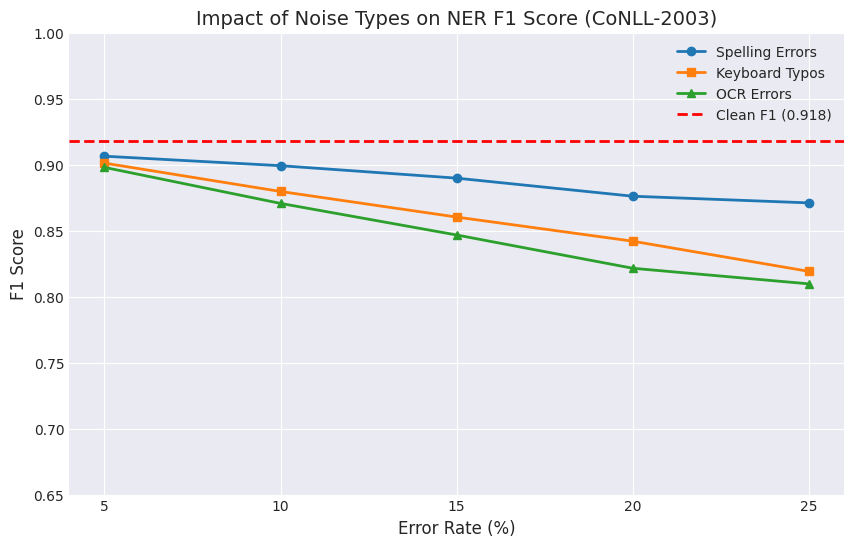

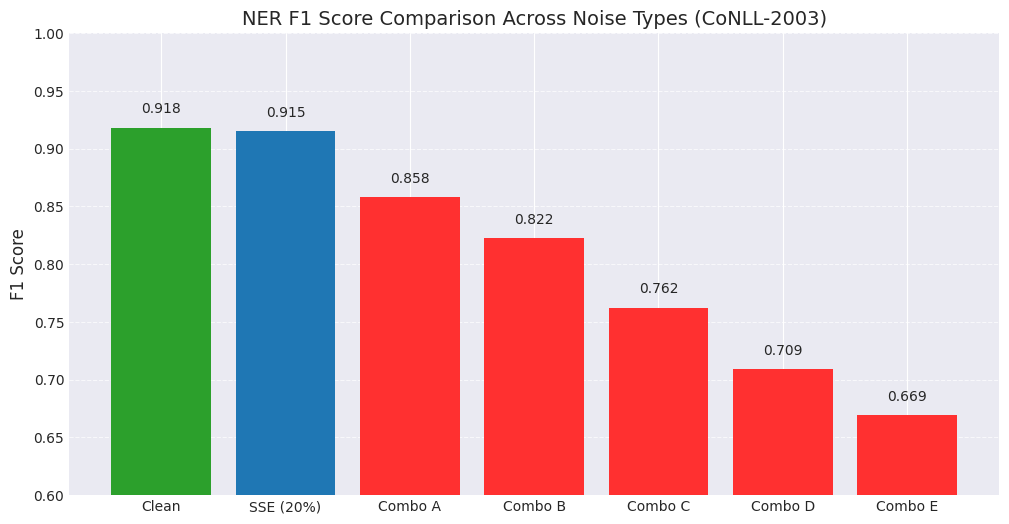

Results saved to ner_noise_results.json


In [32]:
import json
import matplotlib.pyplot as plt
import numpy as np


# Visualization Block - Create plots of results
print("Generating visualization plots...")

# 1. Plot the impact of different noise types on F1 score
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Extract data for plotting
noise_types = ["spelling", "typo", "ocr"]
markers = ['o', 's', '^']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['Spelling Errors', 'Keyboard Typos', 'OCR Errors']

ds = "CoNLL03"  # Only one dataset
clean_f1 = results[ds]["clean"][2]  # F1 score from clean data

for i, noise in enumerate(noise_types):
    if noise in results[ds] and results[ds][noise]:
        error_rates = sorted(results[ds][noise].keys())
        f1_scores = [results[ds][noise][er][2] for er in error_rates]
        # Convert error rates to percentage for plotting
        error_rates_percent = [r * 100 for r in error_rates]
        plt.plot(error_rates_percent, f1_scores, marker=markers[i], linestyle='-', 
                 color=colors[i], label=labels[i], linewidth=2)

# Add horizontal line for clean F1
plt.axhline(y=clean_f1, color='r', linestyle='--', 
            label=f'Clean F1 ({clean_f1:.3f})', linewidth=2)

plt.title('Impact of Noise Types on NER F1 Score (CoNLL-2003)', fontsize=14)
plt.xlabel('Error Rate (%)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.ylim(min(0.65, plt.ylim()[0]), 1.0)  # Adjust y-axis
plt.xticks(error_rates_percent)  # Show ticks for tested rates
plt.savefig("ner_noise_impact_chart.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Comparison of Clean, SSE, and Combined Noise (all scenarios)
plt.figure(figsize=(12, 6))

# Set up bars
scenarios = ['Clean']
f1_values = [clean_f1]
colors = ['#2ca02c']  # Green for clean

# Add SSE
if results[ds].get("sse"):
    scenarios.append(f'SSE ({int(sse_rate*100)}%)')
    f1_values.append(results[ds]["sse"][2])
    colors.append('#1f77b4')  # Blue for SSE

# Add all combo scenarios
combo_results = []
if results[ds].get("combo"):
    for combo_name in sorted(results[ds]["combo"].keys()):
        scenarios.append(f'Combo {combo_name}')
        f1_values.append(results[ds]["combo"][combo_name][2])
        # Progressive red colors for increasingly severe combinations
        colors.append(f'#{min(255, 200 + int(combo_name.upper(), 36) * 10):02x}3030')

bars = plt.bar(scenarios, f1_values, color=colors)
plt.ylabel('F1 Score', fontsize=12)
plt.title('NER F1 Score Comparison Across Noise Types (CoNLL-2003)', fontsize=14)
plt.ylim(min(0.6, min(f1_values)-0.05), 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add F1 scores on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.savefig("ner_noise_comparison_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# Optional: Save the results to a JSON file for later use
with open("ner_noise_results.json", "w") as f:
    # Convert float keys to strings for JSON compatibility
    serializable_results = {}
    for ds_name, ds_results in results.items():
        serializable_results[ds_name] = {}
        for noise_type, noise_results in ds_results.items():
            if isinstance(noise_results, dict):
                serializable_results[ds_name][noise_type] = {
                    str(rate): values for rate, values in noise_results.items()
                }
            else:
                serializable_results[ds_name][noise_type] = noise_results
    
    json.dump(serializable_results, f, indent=2)
    print("Results saved to ner_noise_results.json")

Generating visualization plots...


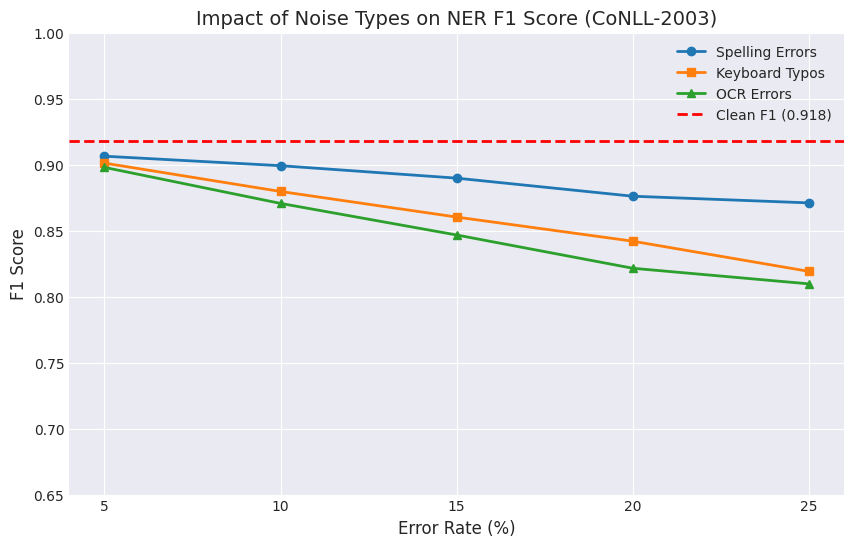

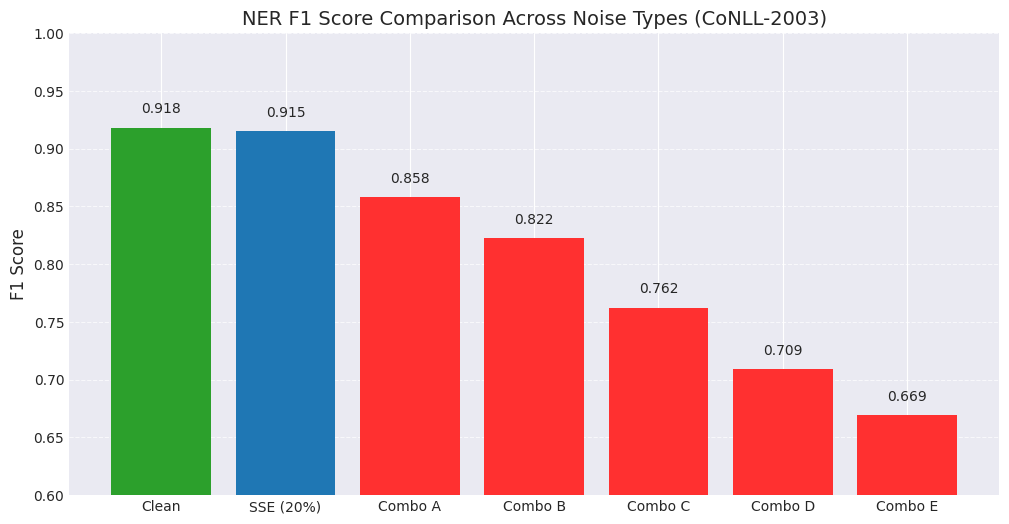

Results saved to ner_noise_results.json


In [33]:
import json
import matplotlib.pyplot as plt
import numpy as np


# Visualization Block - Create plots of results
print("Generating visualization plots...")

# 1. Plot the impact of different noise types on F1 score
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Extract data for plotting
noise_types = ["spelling", "typo", "ocr"]
markers = ['o', 's', '^']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['Spelling Errors', 'Keyboard Typos', 'OCR Errors']

ds = "CoNLL03"  # Only one dataset
clean_f1 = results[ds]["clean"][2]  # F1 score from clean data

for i, noise in enumerate(noise_types):
    if noise in results[ds] and results[ds][noise]:
        error_rates = sorted(results[ds][noise].keys())
        f1_scores = [results[ds][noise][er][2] for er in error_rates]
        # Convert error rates to percentage for plotting
        error_rates_percent = [r * 100 for r in error_rates]
        plt.plot(error_rates_percent, f1_scores, marker=markers[i], linestyle='-', 
                 color=colors[i], label=labels[i], linewidth=2)

# Add horizontal line for clean F1
plt.axhline(y=clean_f1, color='r', linestyle='--', 
            label=f'Clean F1 ({clean_f1:.3f})', linewidth=2)

plt.title('Impact of Noise Types on NER F1 Score (CoNLL-2003)', fontsize=14)
plt.xlabel('Error Rate (%)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.ylim(min(0.65, plt.ylim()[0]), 1.0)  # Adjust y-axis
plt.xticks(error_rates_percent)  # Show ticks for tested rates
plt.savefig("ner_noise_impact_chart.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Comparison of Clean, SSE, and Combined Noise (all scenarios)
plt.figure(figsize=(12, 6))

# Set up bars
scenarios = ['Clean']
f1_values = [clean_f1]
colors = ['#2ca02c']  # Green for clean

# Add SSE
if results[ds].get("sse"):
    scenarios.append(f'SSE ({int(sse_rate*100)}%)')
    f1_values.append(results[ds]["sse"][2])
    colors.append('#1f77b4')  # Blue for SSE

# Add all combo scenarios
combo_results = []
if results[ds].get("combo"):
    for combo_name in sorted(results[ds]["combo"].keys()):
        scenarios.append(f'Combo {combo_name}')
        f1_values.append(results[ds]["combo"][combo_name][2])
        # Progressive red colors for increasingly severe combinations
        colors.append(f'#{min(255, 200 + int(combo_name.upper(), 36) * 10):02x}3030')

bars = plt.bar(scenarios, f1_values, color=colors)
plt.ylabel('F1 Score', fontsize=12)
plt.title('NER F1 Score Comparison Across Noise Types (CoNLL-2003)', fontsize=14)
plt.ylim(min(0.6, min(f1_values)-0.05), 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add F1 scores on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.savefig("ner_noise_comparison_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# Optional: Save the results to a JSON file for later use
with open("ner_noise_results.json", "w") as f:
    # Convert float keys to strings for JSON compatibility
    serializable_results = {}
    for ds_name, ds_results in results.items():
        serializable_results[ds_name] = {}
        for noise_type, noise_results in ds_results.items():
            if isinstance(noise_results, dict):
                serializable_results[ds_name][noise_type] = {
                    str(rate): values for rate, values in noise_results.items()
                }
            else:
                serializable_results[ds_name][noise_type] = noise_results
    
    json.dump(serializable_results, f, indent=2)
    print("Results saved to ner_noise_results.json")




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [sklearn-crfsuite]

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

--- Adding CRF Models Evaluation ---
Creating noisy training data...
Training clean CRF model...
Clean CRF model trained successfully
Training noise-aware CRF model...
Noise-aware CRF model trained successfully

Evaluating both CRF models on clean data...
Clean CRF (clean data): F1=0.9335
Noisy CRF (clean data): F1=0.9301

Evaluating with spelling noise...
Spelling 5%: Clean CRF F1=0.932, Noisy CRF F1=0.928
Spelling 15%: Clean CRF F1=0.928, Noisy CRF F1=0.925
Spelling 25%: Clean CRF F1=0.923, Noisy CRF F1=0.921

Evaluating with typo noise...
Typo 5%: Clean CRF F1=0.928, Noisy CRF F1=0.926
Typo 15%: Clean CRF F1=0.916, Noisy CRF F1=0.919
Typo 25%: Clean CRF F1=0.905, Noisy CRF F1=0.910

Evaluating with OCR noise...
OCR 5%: Clean CRF F1

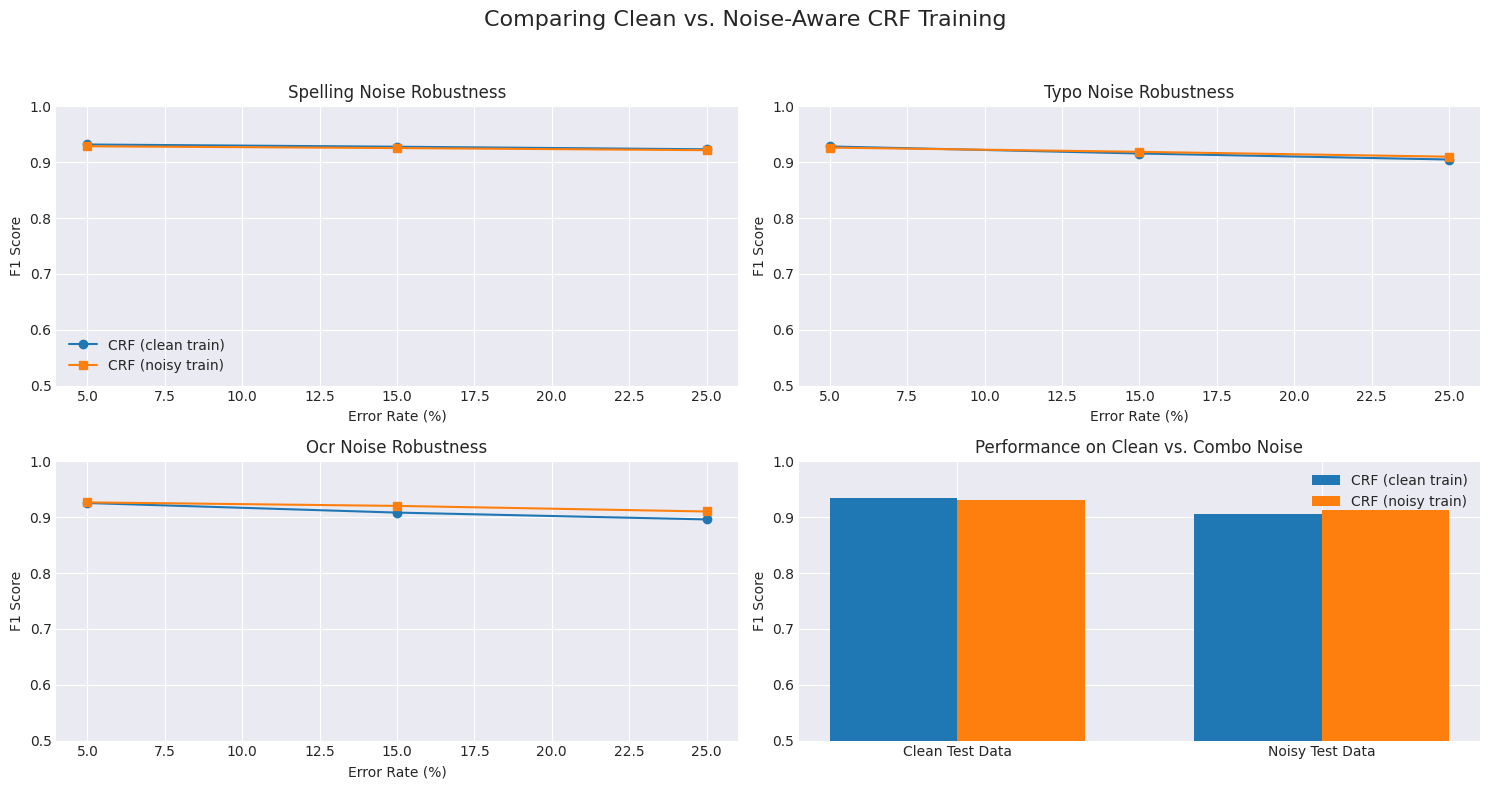


=== BERT vs CRF COMPARATIVE ANALYSIS ===

Clean Test Data Performance:
BERT:           F1=0.9180
CRF (clean):    F1=0.9335
CRF (noisy):    F1=0.9301

High Noise (25%) Performance:

Spelling Noise:
BERT:           F1=0.8710
CRF (clean):    F1=0.9231
CRF (noisy):    F1=0.9215

Typo Noise:
BERT:           F1=0.8191
CRF (clean):    F1=0.9048
CRF (noisy):    F1=0.9098

Ocr Noise:
BERT:           F1=0.8096
CRF (clean):    F1=0.8960
CRF (noisy):    F1=0.9102


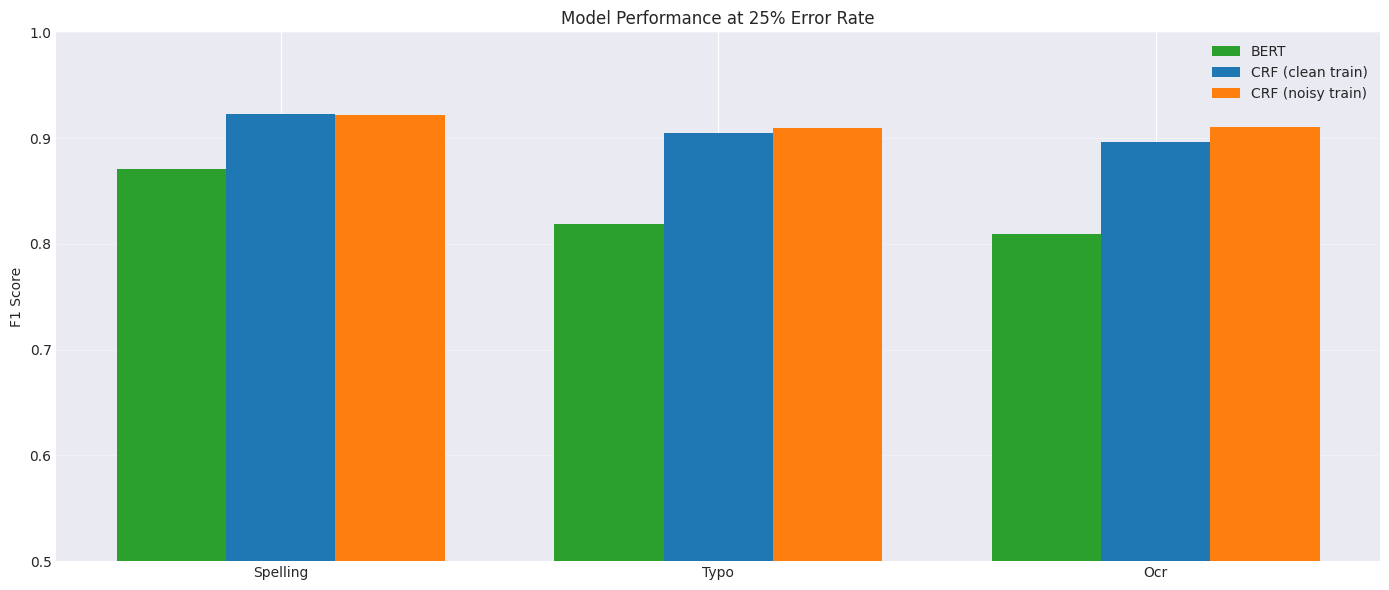

In [34]:
# Install required libraries
!pip install sklearn-crfsuite

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split

print("\n--- Adding CRF Models Evaluation ---")

# Function to extract features for CRF
def word2features(sent, i):
    """Extract features for a token in context"""
    word = sent[i]
    
    # Basic features
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:] if len(word) > 2 else word,
        'word[-2:]': word[-2:] if len(word) > 1 else word,
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word.contains_digit()': any(c.isdigit() for c in word),
        'word.contains_hyphen()': '-' in word,
    }
    
    # Features from previous token
    if i > 0:
        prevword = sent[i-1]
        features.update({
            '-1:word.lower()': prevword.lower(),
            '-1:word.istitle()': prevword.istitle(),
            '-1:word.isupper()': prevword.isupper(),
            '-1:word.contains_digit()': any(c.isdigit() for c in prevword),
        })
    else:
        features['BOS'] = True  # Beginning of sequence
        
    # Features from next token
    if i < len(sent)-1:
        nextword = sent[i+1]
        features.update({
            '+1:word.lower()': nextword.lower(),
            '+1:word.istitle()': nextword.istitle(),
            '+1:word.isupper()': nextword.isupper(),
            '+1:word.contains_digit()': any(c.isdigit() for c in nextword),
        })
    else:
        features['EOS'] = True  # End of sequence
        
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent, label_names):
    return [label_names[tag] for tag in sent]

# Store the label names once to avoid repeated lookups
global_label_names = conll['train'].features['ner_tags'].feature.names

# Prepare data for CRF models
train_data = conll['train']

# Use a subset of training data for speed
max_train_examples = 3000  # Using a smaller subset for faster training
train_sents = []
train_labels = []

for i in range(max_train_examples):
    if i >= len(train_data):
        break
    example = train_data[i]
    train_sents.append(example['tokens'])
    train_labels.append(sent2labels(example['ner_tags'], global_label_names))

# Extract features for clean data
X_train_clean = [sent2features(s) for s in train_sents]
y_train = train_labels

# Create noisy training data (combination of different noise types)
print("Creating noisy training data...")
train_sents_noisy = []
for tokens in train_sents:
    # Apply multiple noise types sequentially with moderate rates
    noisy_tokens = tokens
    noisy_tokens = introduce_spelling_errors(noisy_tokens, 0.1)
    noisy_tokens = introduce_typo_errors(noisy_tokens, 0.1)
    noisy_tokens = introduce_ocr_errors(noisy_tokens, 0.1)
    train_sents_noisy.append(noisy_tokens)

# Extract features for noisy data
X_train_noisy = [sent2features(s) for s in train_sents_noisy]

# Train CRF model on clean data
print("Training clean CRF model...")
crf_clean = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf_clean.fit(X_train_clean, y_train)
print("Clean CRF model trained successfully")

# Train CRF model on noisy data
print("Training noise-aware CRF model...")
crf_noisy = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf_noisy.fit(X_train_noisy, y_train)
print("Noise-aware CRF model trained successfully")

# Helper function to evaluate CRF models with noise
def evaluate_crf_models(dataset, noise_type=None, error_rate=0.0, label_names=None):
    """Evaluate both CRF models on the given dataset with specified noise type"""
    # Get label names - handle different dataset types
    if label_names is None:
        # Try to get from dataset if it's a HuggingFace dataset
        if hasattr(dataset, 'features') and 'ner_tags' in dataset.features:
            label_names = dataset.features['ner_tags'].feature.names
        else:
            # Fall back to the global label names
            label_names = global_label_names
    
    # Initialize results collections for both models
    true_labels_all = []
    pred_labels_clean_all = []
    pred_labels_noisy_all = []
    
    # Decide which noise function to apply
    noise_func = None
    if noise_type == "spelling":
        noise_func = introduce_spelling_errors
    elif noise_type == "typo":
        noise_func = introduce_typo_errors
    elif noise_type == "ocr":
        noise_func = introduce_ocr_errors
    
    # Check dataset type and process accordingly
    if hasattr(dataset, '__getitem__') and hasattr(dataset, '__len__'):
        examples = [dataset[i] for i in range(len(dataset))]
    else:
        examples = dataset  # Already a list
    
    # For each example in the dataset
    for example in examples:
        tokens = example['tokens']
        tags = example['ner_tags']
        
        # Convert numeric tags to label strings
        true_labels = [label_names[tag] for tag in tags]
        
        # Apply noise if specified
        corrupted_tokens = tokens
        if noise_func:
            corrupted_tokens = noise_func(tokens, error_rate)
        
        # Get features for CRF
        X_test = [sent2features(corrupted_tokens)]
        
        # Predict with clean CRF model
        y_pred_clean = crf_clean.predict(X_test)
        pred_labels_clean = y_pred_clean[0]
        
        # Predict with noisy CRF model
        y_pred_noisy = crf_noisy.predict(X_test)
        pred_labels_noisy = y_pred_noisy[0]
        
        # Ensure predictions match the length of true labels
        if len(pred_labels_clean) < len(true_labels):
            pred_labels_clean += ['O'] * (len(true_labels) - len(pred_labels_clean))
        elif len(pred_labels_clean) > len(true_labels):
            pred_labels_clean = pred_labels_clean[:len(true_labels)]
        
        if len(pred_labels_noisy) < len(true_labels):
            pred_labels_noisy += ['O'] * (len(true_labels) - len(pred_labels_noisy))
        elif len(pred_labels_noisy) > len(true_labels):
            pred_labels_noisy = pred_labels_noisy[:len(true_labels)]
        
        true_labels_all.append(true_labels)
        pred_labels_clean_all.append(pred_labels_clean)
        pred_labels_noisy_all.append(pred_labels_noisy)
    
    # Calculate metrics for clean CRF
    clean_p = metrics.flat_precision_score(true_labels_all, pred_labels_clean_all, average='weighted')
    clean_r = metrics.flat_recall_score(true_labels_all, pred_labels_clean_all, average='weighted')
    clean_f1 = metrics.flat_f1_score(true_labels_all, pred_labels_clean_all, average='weighted')
    
    # Calculate metrics for noisy CRF
    noisy_p = metrics.flat_precision_score(true_labels_all, pred_labels_noisy_all, average='weighted')
    noisy_r = metrics.flat_recall_score(true_labels_all, pred_labels_noisy_all, average='weighted')
    noisy_f1 = metrics.flat_f1_score(true_labels_all, pred_labels_noisy_all, average='weighted')
    
    return (clean_p, clean_r, clean_f1), (noisy_p, noisy_r, noisy_f1)

# Initialize results dictionary for both CRF models
crf_results = {
    "clean_model": {"clean": None, "spelling": {}, "typo": {}, "ocr": {}, "combo": {}},
    "noisy_model": {"clean": None, "spelling": {}, "typo": {}, "ocr": {}, "combo": {}}
}

# Create a list of examples for easier handling
test_examples = []
for i in range(len(conll['test'])):
    test_examples.append(conll['test'][i])

# Step 1: Evaluate on clean data
print("\nEvaluating both CRF models on clean data...")
clean_metrics, noisy_metrics = evaluate_crf_models(test_examples)
crf_results["clean_model"]["clean"] = clean_metrics
crf_results["noisy_model"]["clean"] = noisy_metrics
print(f"Clean CRF (clean data): F1={clean_metrics[2]:.4f}")
print(f"Noisy CRF (clean data): F1={noisy_metrics[2]:.4f}")

# Step 2: Evaluate with spelling noise
print("\nEvaluating with spelling noise...")
for er in [0.05, 0.15, 0.25]:  # Three rates for a good trend line
    clean_metrics, noisy_metrics = evaluate_crf_models(test_examples, noise_type="spelling", error_rate=er)
    crf_results["clean_model"]["spelling"][er] = clean_metrics
    crf_results["noisy_model"]["spelling"][er] = noisy_metrics
    print(f"Spelling {int(er*100)}%: Clean CRF F1={clean_metrics[2]:.3f}, Noisy CRF F1={noisy_metrics[2]:.3f}")

# Step 3: Evaluate with typo noise
print("\nEvaluating with typo noise...")
for er in [0.05, 0.15, 0.25]:
    clean_metrics, noisy_metrics = evaluate_crf_models(test_examples, noise_type="typo", error_rate=er)
    crf_results["clean_model"]["typo"][er] = clean_metrics
    crf_results["noisy_model"]["typo"][er] = noisy_metrics
    print(f"Typo {int(er*100)}%: Clean CRF F1={clean_metrics[2]:.3f}, Noisy CRF F1={noisy_metrics[2]:.3f}")

# Step 4: Evaluate with OCR noise
print("\nEvaluating with OCR noise...")
for er in [0.05, 0.15, 0.25]:
    clean_metrics, noisy_metrics = evaluate_crf_models(test_examples, noise_type="ocr", error_rate=er)
    crf_results["clean_model"]["ocr"][er] = clean_metrics
    crf_results["noisy_model"]["ocr"][er] = noisy_metrics
    print(f"OCR {int(er*100)}%: Clean CRF F1={clean_metrics[2]:.3f}, Noisy CRF F1={noisy_metrics[2]:.3f}")

# Step 5: Evaluate with combo noise (similar to training)
print("\nEvaluating with combo noise...")
combo_test_data = []
for example in test_examples:
    tokens = example['tokens']
    tags = example['ner_tags']
    # Apply sequential noise
    noisy_tokens = introduce_spelling_errors(tokens, 0.1)
    noisy_tokens = introduce_typo_errors(noisy_tokens, 0.1)
    noisy_tokens = introduce_ocr_errors(noisy_tokens, 0.1)
    combo_test_data.append({"tokens": noisy_tokens, "ner_tags": tags})

# Explicitly pass label_names to avoid the error
clean_metrics, noisy_metrics = evaluate_crf_models(combo_test_data, label_names=global_label_names)
crf_results["clean_model"]["combo"]["standard"] = clean_metrics
crf_results["noisy_model"]["combo"]["standard"] = noisy_metrics
print(f"Combo noise: Clean CRF F1={clean_metrics[2]:.3f}, Noisy CRF F1={noisy_metrics[2]:.3f}")

# Step 6: Compare models
print("\n=== CRF MODELS COMPARISON SUMMARY ===")
print("\nClean Test Data Performance:")
print(f"CRF (clean training): F1={crf_results['clean_model']['clean'][2]:.4f}")
print(f"CRF (noisy training): F1={crf_results['noisy_model']['clean'][2]:.4f}")

print("\nCombo Noise Test Performance:")
print(f"CRF (clean training): F1={crf_results['clean_model']['combo']['standard'][2]:.4f}")
print(f"CRF (noisy training): F1={crf_results['noisy_model']['combo']['standard'][2]:.4f}")

# Create comparative visualization
plt.figure(figsize=(15, 8))
plt.style.use('seaborn-v0_8-darkgrid')

# Setup for comparison chart
noise_types = ["spelling", "typo", "ocr"]
error_rates = [0.05, 0.15, 0.25]
models = ["CRF (clean train)", "CRF (noisy train)"]
colors = ['#1f77b4', '#ff7f0e']

# Plot noise robustness for each noise type
for i, noise in enumerate(noise_types):
    plt.subplot(2, 2, i+1)
    
    # Extract F1 scores for both models across error rates
    clean_f1 = [crf_results["clean_model"][noise][er][2] for er in error_rates]
    noisy_f1 = [crf_results["noisy_model"][noise][er][2] for er in error_rates]
    
    # Plot lines
    plt.plot([er*100 for er in error_rates], clean_f1, 'o-', color=colors[0], label=models[0])
    plt.plot([er*100 for er in error_rates], noisy_f1, 's-', color=colors[1], label=models[1])
    
    # Labels and formatting
    plt.title(f"{noise.capitalize()} Noise Robustness")
    plt.xlabel("Error Rate (%)")
    plt.ylabel("F1 Score")
    plt.grid(True)
    if i == 0:
        plt.legend()
    plt.ylim(0.5, 1.0)

# Add combo noise comparison in 4th subplot
plt.subplot(2, 2, 4)
combo_f1 = [
    crf_results["clean_model"]["clean"][2],  # Clean data, clean model
    crf_results["noisy_model"]["clean"][2],  # Clean data, noisy model 
    crf_results["clean_model"]["combo"]["standard"][2],  # Combo noise, clean model
    crf_results["noisy_model"]["combo"]["standard"][2]   # Combo noise, noisy model
]

# Create bar chart
x = np.arange(2)
width = 0.35
plt.bar(x - width/2, [combo_f1[0], combo_f1[2]], width, label='CRF (clean train)', color=colors[0])
plt.bar(x + width/2, [combo_f1[1], combo_f1[3]], width, label='CRF (noisy train)', color=colors[1])

plt.xticks(x, ['Clean Test Data', 'Noisy Test Data'])
plt.ylabel('F1 Score')
plt.title('Performance on Clean vs. Combo Noise')
plt.legend()
plt.ylim(0.5, 1.0)

plt.suptitle("Comparing Clean vs. Noise-Aware CRF Training", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("crf_clean_vs_noisy_training.png", dpi=300, bbox_inches='tight')
plt.show()


# Comparative analysis with BERT
print("\n=== BERT vs CRF COMPARATIVE ANALYSIS ===")
print("\nClean Test Data Performance:")
print(f"BERT:           F1={results['CoNLL03']['clean'][2]:.4f}")
print(f"CRF (clean):    F1={crf_results['clean_model']['clean'][2]:.4f}")
print(f"CRF (noisy):    F1={crf_results['noisy_model']['clean'][2]:.4f}")

# Find the correct key format for the BERT results
print("\nHigh Noise (25%) Performance:")
for noise in noise_types:
    # Check what format the keys are stored in
    bert_keys = list(results['CoNLL03'][noise].keys())
    # Find the key that represents 0.25 (either as float or string)
    target_key = None
    for key in bert_keys:
        if isinstance(key, float) and abs(key - 0.25) < 0.001:
            target_key = key
            break
        elif isinstance(key, str) and abs(float(key) - 0.25) < 0.001:
            target_key = key
            break
    
    if target_key is not None:
        print(f"\n{noise.capitalize()} Noise:")
        print(f"BERT:           F1={results['CoNLL03'][noise][target_key][2]:.4f}")
        print(f"CRF (clean):    F1={crf_results['clean_model'][noise][0.25][2]:.4f}")
        print(f"CRF (noisy):    F1={crf_results['noisy_model'][noise][0.25][2]:.4f}")
    else:
        print(f"\n{noise.capitalize()} Noise: BERT results not available at 25% level")

# Create a model comparison visualization
plt.figure(figsize=(14, 6))

# Compare all models at 25% noise level
x = np.arange(len(noise_types))
width = 0.25

# Prepare data for visualization with proper error handling
bert_f1_values = []
for nt in noise_types:
    bert_keys = list(results['CoNLL03'][nt].keys())
    target_key = None
    for key in bert_keys:
        if (isinstance(key, float) and abs(key - 0.25) < 0.001) or \
           (isinstance(key, str) and abs(float(key) - 0.25) < 0.001):
            target_key = key
            break
    
    # If found, use the value, otherwise use None
    if target_key is not None:
        bert_f1_values.append(results['CoNLL03'][nt][target_key][2])
    else:
        # Use a placeholder value if BERT results for this noise type are missing
        bert_f1_values.append(None)

# Filter out noise types where BERT results are missing
valid_indices = [i for i, val in enumerate(bert_f1_values) if val is not None]
if valid_indices:
    plt.bar([x[i] - width for i in valid_indices], 
            [bert_f1_values[i] for i in valid_indices], 
            width, label='BERT', color='#2ca02c')
    plt.bar(x, [crf_results['clean_model'][nt][0.25][2] for nt in noise_types],
            width, label='CRF (clean train)', color='#1f77b4')
    plt.bar(x + width, [crf_results['noisy_model'][nt][0.25][2] for nt in noise_types],
            width, label='CRF (noisy train)', color='#ff7f0e')

    plt.ylabel('F1 Score')
    plt.title('Model Performance at 25% Error Rate')
    plt.xticks(x, [nt.capitalize() for nt in noise_types])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0.5, 1.0)

    plt.tight_layout()
    plt.savefig("bert_vs_crfs_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Cannot create comparison visualization: No valid BERT results found at 25% error rate")